In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 数据加载与预处理
# ============================================================================

# Load data - 请根据实际路径修改
df = pd.read_csv('..//data//HEAs_hardness_Data.csv', index_col=0)

# Split different types of features
comp_features = np.array(df.iloc[:, 18:39])  # 成分特征
physical_features = np.array(df.iloc[:, 1:13])  # 物理特征
all_features = np.hstack((comp_features, physical_features))

# Target variable
y = np.array(df.iloc[:, 39])

# 标准化特征
scaler_comp = StandardScaler()
comp_features_scaled = scaler_comp.fit_transform(comp_features)

scaler_physical = StandardScaler()
physical_features_scaled = scaler_physical.fit_transform(physical_features)

scaler_all = StandardScaler()
all_features_scaled = scaler_all.fit_transform(all_features)

# **关键改进：标准化目标变量**
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()


Model: ANN

──────────────────────────────────────────────────
Feature Combination: Composition Only
──────────────────────────────────────────────────

ANN 开始贝叶斯超参数优化...
  最优参数: hidden_layers=(235, 61), alpha=0.000100, lr=0.010000

ANN 10-Fold Cross Validation Started...
Fold  1: RMSE = 59.6891, R² = 0.8948, MAE = 43.7309
Fold  2: RMSE = 58.9190, R² = 0.8955, MAE = 40.1929
Fold  3: RMSE = 75.5705, R² = 0.8512, MAE = 47.4409
Fold  4: RMSE = 110.0189, R² = 0.7878, MAE = 55.9714
Fold  5: RMSE = 80.7161, R² = 0.8535, MAE = 54.7984
Fold  6: RMSE = 73.0796, R² = 0.9179, MAE = 49.0158
Fold  7: RMSE = 58.3873, R² = 0.9172, MAE = 44.3372
Fold  8: RMSE = 96.6254, R² = 0.8028, MAE = 49.2266
Fold  9: RMSE = 77.9989, R² = 0.8237, MAE = 44.4962
Fold 10: RMSE = 62.5039, R² = 0.9122, MAE = 45.2520
Mean RMSE: 75.3509 (±16.3205)
Mean R²  : 0.8657 (±0.0463)
Mean MAE : 47.4462 (±4.7113)

──────────────────────────────────────────────────
Feature Combination: Physical Only
───────────────────────────────

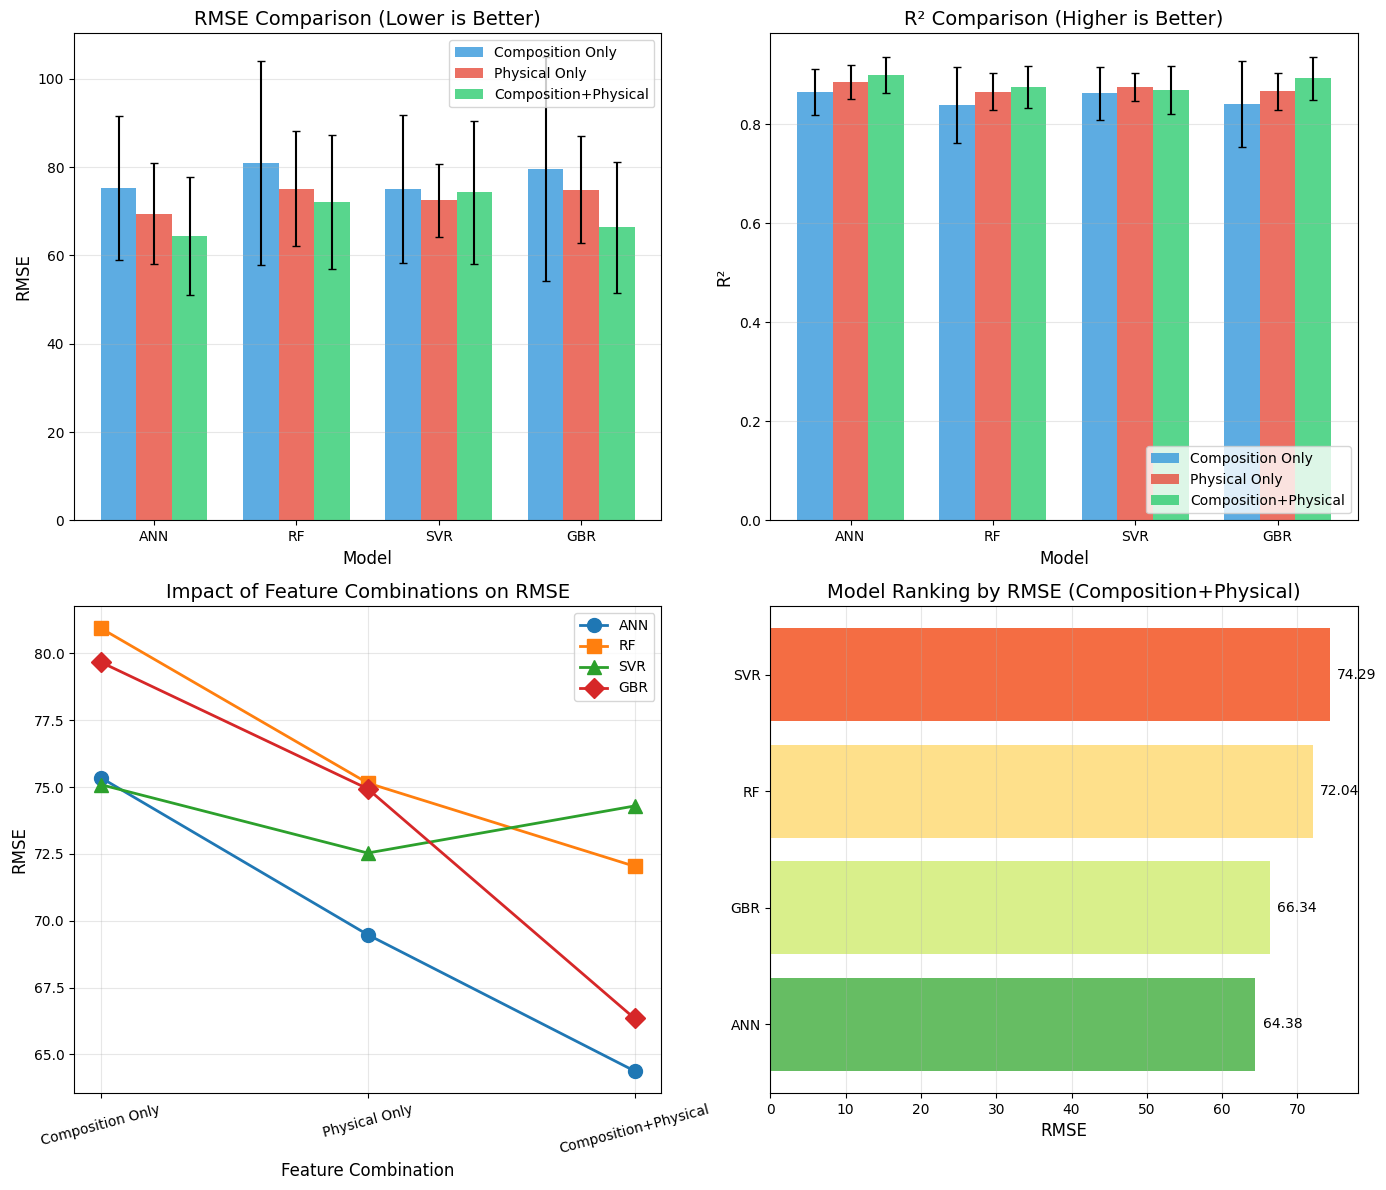


Best Model Analysis
 Feature Combination Best Model Best RMSE Corresponding R² Corresponding MAE
    Composition Only        SVR   75.0896           0.8627           52.9067
       Physical Only        ANN   69.4774           0.8849           48.6998
Composition+Physical        ANN   64.3785           0.8995           42.2288

Overall Model Ranking (by Mean RMSE across all feature combinations)

Rank  Model     Avg RMSE    Avg R²    
--------------------------------------
1     ANN       69.7356     0.8833    
2     GBR       73.6500     0.8671    
3     SVR       73.9701     0.8691    
4     RF        76.0422     0.8606    


In [2]:


# 特征组合字典
feature_combinations = {
    'Composition Only': comp_features_scaled,
    'Physical Only': physical_features_scaled,
    'Composition+Physical': all_features_scaled
}

# ============================================================================
# 贝叶斯优化函数 - 四个模型
# ============================================================================

def ann_cv(hidden1, hidden2, alpha, learning_rate_init, X_train, y_train):
    """ANN贝叶斯优化目标函数"""
    hidden1 = int(hidden1)
    hidden2 = int(hidden2)
    
    model = MLPRegressor(
        hidden_layer_sizes=(hidden1, hidden2),
        activation='relu',
        solver='adam',
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=2000,
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=20,
        random_state=42
    )
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        scores.append(-np.sqrt(mean_squared_error(y_val, y_pred)))
    return np.mean(scores)


def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, X_train, y_train):
    """随机森林贝叶斯优化目标函数"""
    model = RandomForestRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        scores.append(-np.sqrt(mean_squared_error(y_val, y_pred)))
    return np.mean(scores)


def svr_cv(C, epsilon, gamma, X_train, y_train):
    """SVR贝叶斯优化目标函数"""
    model = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel='rbf')
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        scores.append(-np.sqrt(mean_squared_error(y_val, y_pred)))
    return np.mean(scores)


def gbr_cv(n_estimators, max_depth, learning_rate, min_samples_split, subsample, X_train, y_train):
    """GradientBoosting贝叶斯优化目标函数"""
    model = GradientBoostingRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        min_samples_split=int(min_samples_split),
        subsample=subsample,
        random_state=42
    )
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        scores.append(-np.sqrt(mean_squared_error(y_val, y_pred)))
    return np.mean(scores)


# ============================================================================
# 主函数：带超参数优化的十折交叉验证
# ============================================================================

def ten_fold_cross_validation_optimized(model_name, X, y_original, y_std, scaler_y, random_state=75):
    """
    执行带贝叶斯优化的十折交叉验证
    """
    
    print(f"\n{model_name} 开始贝叶斯超参数优化...")
    
    # ========== ANN超参数优化 ==========
    if model_name == 'ANN':
        optimizer = BayesianOptimization(
            f=lambda hidden1, hidden2, alpha, learning_rate_init: 
                ann_cv(hidden1, hidden2, alpha, learning_rate_init, X, y_std),
            pbounds={
                'hidden1': (50, 300),
                'hidden2': (20, 150),
                'alpha': (0.0001, 0.1),
                'learning_rate_init': (0.0001, 0.01)
            },
            random_state=42,
            verbose=0
        )
        optimizer.maximize(init_points=15, n_iter=35)
        best_params = optimizer.max['params']
        
        model = MLPRegressor(
            hidden_layer_sizes=(int(best_params['hidden1']), int(best_params['hidden2'])),
            activation='relu',
            solver='adam',
            alpha=best_params['alpha'],
            learning_rate_init=best_params['learning_rate_init'],
            max_iter=2000,
            early_stopping=True,
            validation_fraction=0.15,
            n_iter_no_change=20,
            random_state=42
        )
        print(f"  最优参数: hidden_layers=({int(best_params['hidden1'])}, {int(best_params['hidden2'])}), "
              f"alpha={best_params['alpha']:.6f}, lr={best_params['learning_rate_init']:.6f}")
    
    # ========== 随机森林超参数优化 ==========
    elif model_name == 'RF':
        optimizer = BayesianOptimization(
            f=lambda n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features:
                rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, X, y_std),
            pbounds={
                'n_estimators': (100, 500),
                'max_depth': (5, 30),
                'min_samples_split': (2, 20),
                'min_samples_leaf': (1, 10),
                'max_features': (0.3, 1.0)
            },
            random_state=42,
            verbose=0
        )
        optimizer.maximize(init_points=15, n_iter=35)
        best_params = optimizer.max['params']
        
        model = RandomForestRegressor(
            n_estimators=int(best_params['n_estimators']),
            max_depth=int(best_params['max_depth']),
            min_samples_split=int(best_params['min_samples_split']),
            min_samples_leaf=int(best_params['min_samples_leaf']),
            max_features=best_params['max_features'],
            random_state=42,
            n_jobs=-1
        )
        print(f"  最优参数: n_estimators={int(best_params['n_estimators'])}, "
              f"max_depth={int(best_params['max_depth'])}, "
              f"min_samples_split={int(best_params['min_samples_split'])}, "
              f"max_features={best_params['max_features']:.3f}")
    
    # ========== SVR超参数优化 ==========
    elif model_name == 'SVR':
        optimizer = BayesianOptimization(
            f=lambda C, epsilon, gamma: svr_cv(C, epsilon, gamma, X, y_std),
            pbounds={
                'C': (0.1, 100),
                'epsilon': (0.001, 1),
                'gamma': (0.001, 1)
            },
            random_state=42,
            verbose=0
        )
        optimizer.maximize(init_points=20, n_iter=40)
        best_params = optimizer.max['params']
        
        model = SVR(
            C=best_params['C'],
            epsilon=best_params['epsilon'],
            gamma=best_params['gamma'],
            kernel='rbf'
        )
        print(f"  最优参数: C={best_params['C']:.4f}, "
              f"epsilon={best_params['epsilon']:.6f}, "
              f"gamma={best_params['gamma']:.6f}")
    
    # ========== GradientBoosting超参数优化 ==========
    elif model_name == 'GBR':
        optimizer = BayesianOptimization(
            f=lambda n_estimators, max_depth, learning_rate, min_samples_split, subsample:
                gbr_cv(n_estimators, max_depth, learning_rate, min_samples_split, subsample, X, y_std),
            pbounds={
                'n_estimators': (100, 500),
                'max_depth': (3, 15),
                'learning_rate': (0.01, 0.3),
                'min_samples_split': (2, 20),
                'subsample': (0.6, 1.0)
            },
            random_state=42,
            verbose=0
        )
        optimizer.maximize(init_points=15, n_iter=35)
        best_params = optimizer.max['params']
        
        model = GradientBoostingRegressor(
            n_estimators=int(best_params['n_estimators']),
            max_depth=int(best_params['max_depth']),
            learning_rate=best_params['learning_rate'],
            min_samples_split=int(best_params['min_samples_split']),
            subsample=best_params['subsample'],
            random_state=42
        )
        print(f"  最优参数: n_estimators={int(best_params['n_estimators'])}, "
              f"max_depth={int(best_params['max_depth'])}, "
              f"learning_rate={best_params['learning_rate']:.4f}, "
              f"subsample={best_params['subsample']:.3f}")
    
    # ========== 十折交叉验证评估 ==========
    kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)
    
    rmse_scores = []
    r2_scores = []
    mae_scores = []
    
    print(f"\n{model_name} 10-Fold Cross Validation Started...")
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X), 1):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train_std, y_val_std = y_std[train_idx], y_std[val_idx]
        y_val_original = y_original[val_idx]
        
        # 训练模型（使用标准化的y）
        model.fit(X_train, y_train_std)
        
        # 预测（标准化空间）
        y_pred_std = model.predict(X_val)
        
        # 反标准化预测值
        y_pred = scaler_y.inverse_transform(y_pred_std.reshape(-1, 1)).ravel()
        
        # 计算评估指标（在原始空间）
        rmse = np.sqrt(mean_squared_error(y_val_original, y_pred))
        r2 = r2_score(y_val_original, y_pred)
        mae = mean_absolute_error(y_val_original, y_pred)
        
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        mae_scores.append(mae)
        
        print(f"Fold {fold:2d}: RMSE = {rmse:.4f}, R² = {r2:.4f}, MAE = {mae:.4f}")
    
    # 计算平均指标
    mean_rmse = np.mean(rmse_scores)
    std_rmse = np.std(rmse_scores)
    mean_r2 = np.mean(r2_scores)
    std_r2 = np.std(r2_scores)
    mean_mae = np.mean(mae_scores)
    std_mae = np.std(mae_scores)
    
    print(f"Mean RMSE: {mean_rmse:.4f} (±{std_rmse:.4f})")
    print(f"Mean R²  : {mean_r2:.4f} (±{std_r2:.4f})")
    print(f"Mean MAE : {mean_mae:.4f} (±{std_mae:.4f})")
    
    return {
        'RMSE': rmse_scores,
        'R2': r2_scores,
        'MAE': mae_scores,
        'mean_RMSE': mean_rmse,
        'std_RMSE': std_rmse,
        'mean_R2': mean_r2,
        'std_R2': std_r2,
        'mean_MAE': mean_mae,
        'std_MAE': std_mae
    }


# ============================================================================
# 运行所有实验
# ============================================================================

results = {}

# 四个模型列表
model_names = ['ANN', 'RF', 'SVR', 'GBR']

for model_name in model_names:
    model_results = {}
    print(f"\n{'='*70}")
    print(f"Model: {model_name}")
    print('='*70)
    
    for feature_name, X_features in feature_combinations.items():
        print(f"\n{'─'*50}")
        print(f"Feature Combination: {feature_name}")
        print('─'*50)
        
        # 执行带优化的十折交叉验证
        result = ten_fold_cross_validation_optimized(
            model_name, 
            X_features, 
            y,           # 原始y用于评估
            y_scaled,    # 标准化y用于训练
            scaler_y
        )
        model_results[feature_name] = result
    
    results[model_name] = model_results


# ============================================================================
# 结果汇总
# ============================================================================

print("\n" + "="*100)
print("Results Summary (4 Models: ANN, RF, SVR, GBR)")
print("="*100)

summary_data = []
for model_name in model_names:
    for feature_name in feature_combinations.keys():
        result = results[model_name][feature_name]
        summary_data.append({
            'Model': model_name,
            'Feature Combination': feature_name,
            'Mean RMSE': f"{result['mean_RMSE']:.4f}",
            'RMSE Std': f"{result['std_RMSE']:.4f}",
            'Mean R²': f"{result['mean_R2']:.4f}",
            'R² Std': f"{result['std_R2']:.4f}",
            'Mean MAE': f"{result['mean_MAE']:.4f}",
            'MAE Std': f"{result['std_MAE']:.4f}"
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# 保存结果
summary_df.to_csv('model_comparison_results.csv', index=False, encoding='utf-8-sig')
print("\nResults saved to 'model_comparison_results.csv'")


# ============================================================================
# 可视化
# ============================================================================

import matplotlib.pyplot as plt

# 创建图形
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. RMSE对比（柱状图）
ax1 = axes[0, 0]
x_pos = np.arange(len(model_names))
bar_width = 0.25

colors = ['#3498db', '#e74c3c', '#2ecc71']
for i, feature_name in enumerate(feature_combinations.keys()):
    rmse_values = [results[model][feature_name]['mean_RMSE'] for model in model_names]
    rmse_stds = [results[model][feature_name]['std_RMSE'] for model in model_names]
    ax1.bar(x_pos + i*bar_width, rmse_values, bar_width, 
            yerr=rmse_stds, capsize=3, label=feature_name, color=colors[i], alpha=0.8)

ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('RMSE', fontsize=12)
ax1.set_title('RMSE Comparison (Lower is Better)', fontsize=14)
ax1.set_xticks(x_pos + bar_width)
ax1.set_xticklabels(model_names)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3, axis='y')

# 2. R²对比（柱状图）
ax2 = axes[0, 1]
for i, feature_name in enumerate(feature_combinations.keys()):
    r2_values = [results[model][feature_name]['mean_R2'] for model in model_names]
    r2_stds = [results[model][feature_name]['std_R2'] for model in model_names]
    ax2.bar(x_pos + i*bar_width, r2_values, bar_width,
            yerr=r2_stds, capsize=3, label=feature_name, color=colors[i], alpha=0.8)

ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('R²', fontsize=12)
ax2.set_title('R² Comparison (Higher is Better)', fontsize=14)
ax2.set_xticks(x_pos + bar_width)
ax2.set_xticklabels(model_names)
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3, axis='y')

# 3. 各模型在不同特征组合下的RMSE变化（折线图）
ax3 = axes[1, 0]
markers = ['o', 's', '^', 'D']
for i, model_name in enumerate(model_names):
    rmse_values = [results[model_name][feature]['mean_RMSE'] for feature in feature_combinations.keys()]
    ax3.plot(range(len(feature_combinations)), rmse_values, 
             marker=markers[i], linewidth=2, markersize=10, label=model_name)

ax3.set_xlabel('Feature Combination', fontsize=12)
ax3.set_ylabel('RMSE', fontsize=12)
ax3.set_title('Impact of Feature Combinations on RMSE', fontsize=14)
ax3.set_xticks(range(len(feature_combinations)))
ax3.set_xticklabels(list(feature_combinations.keys()), rotation=15)
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

# 4. 最佳特征组合下的模型排名（水平柱状图）
ax4 = axes[1, 1]
feature_name = 'Composition+Physical'
rmse_values = [(model, results[model][feature_name]['mean_RMSE']) for model in model_names]
rmse_values.sort(key=lambda x: x[1])  # 按RMSE排序

models_sorted = [x[0] for x in rmse_values]
values_sorted = [x[1] for x in rmse_values]

# 使用颜色渐变
colors_gradient = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(models_sorted)))
bars = ax4.barh(range(len(models_sorted)), values_sorted, color=colors_gradient)

ax4.set_yticks(range(len(models_sorted)))
ax4.set_yticklabels(models_sorted)
ax4.set_xlabel('RMSE', fontsize=12)
ax4.set_title(f'Model Ranking by RMSE ({feature_name})', fontsize=14)
ax4.grid(True, alpha=0.3, axis='x')

# 添加数值标签
for i, (bar, val) in enumerate(zip(bars, values_sorted)):
    ax4.text(val + 1, i, f'{val:.2f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('model_performance_comparison_4models.png', dpi=300, bbox_inches='tight')
plt.show()


# ============================================================================
# 最佳模型分析
# ============================================================================

print("\n" + "="*100)
print("Best Model Analysis")
print("="*100)

best_results = []
for feature_name in feature_combinations.keys():
    best_rmse = float('inf')
    best_model = None
    
    for model_name in model_names:
        rmse = results[model_name][feature_name]['mean_RMSE']
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model_name
    
    best_results.append({
        'Feature Combination': feature_name,
        'Best Model': best_model,
        'Best RMSE': f"{best_rmse:.4f}",
        'Corresponding R²': f"{results[best_model][feature_name]['mean_R2']:.4f}",
        'Corresponding MAE': f"{results[best_model][feature_name]['mean_MAE']:.4f}"
    })

best_df = pd.DataFrame(best_results)
print(best_df.to_string(index=False))


# ============================================================================
# 总体排名
# ============================================================================

print("\n" + "="*100)
print("Overall Model Ranking (by Mean RMSE across all feature combinations)")
print("="*100)

overall_ranking = []
for model_name in model_names:
    mean_rmse_all = np.mean([results[model_name][f]['mean_RMSE'] for f in feature_combinations.keys()])
    mean_r2_all = np.mean([results[model_name][f]['mean_R2'] for f in feature_combinations.keys()])
    overall_ranking.append({
        'Model': model_name,
        'Avg RMSE': mean_rmse_all,
        'Avg R²': mean_r2_all
    })

overall_ranking.sort(key=lambda x: x['Avg RMSE'])

print(f"\n{'Rank':<6}{'Model':<10}{'Avg RMSE':<12}{'Avg R²':<10}")
print("-" * 38)
for i, item in enumerate(overall_ranking, 1):
    print(f"{i:<6}{item['Model']:<10}{item['Avg RMSE']:<12.4f}{item['Avg R²']:<10.4f}")

the proposed model - Mean RMSE: 57.6050, Std RMSE: 16.7251

图表已保存至 'rmse_model_comparison.png'

RMSE Results Summary

Model               Feature Combination           Mean RMSE      Std RMSE       
--------------------------------------------------------------------------------
ANN                 Composition Only              75.3509        16.3205        
ANN                 Physical Only                 69.4774        11.4612        
ANN                 Composition+Physical          64.3785        13.3727        
RF                  Composition Only              80.9409        23.0999        
RF                  Physical Only                 75.1501        12.9603        
RF                  Composition+Physical          72.0356        15.1902        
SVR                 Composition Only              75.0896        16.8161        
SVR                 Physical Only                 72.5308        8.2938         
SVR                 Composition+Physical          74.2899        16.2640

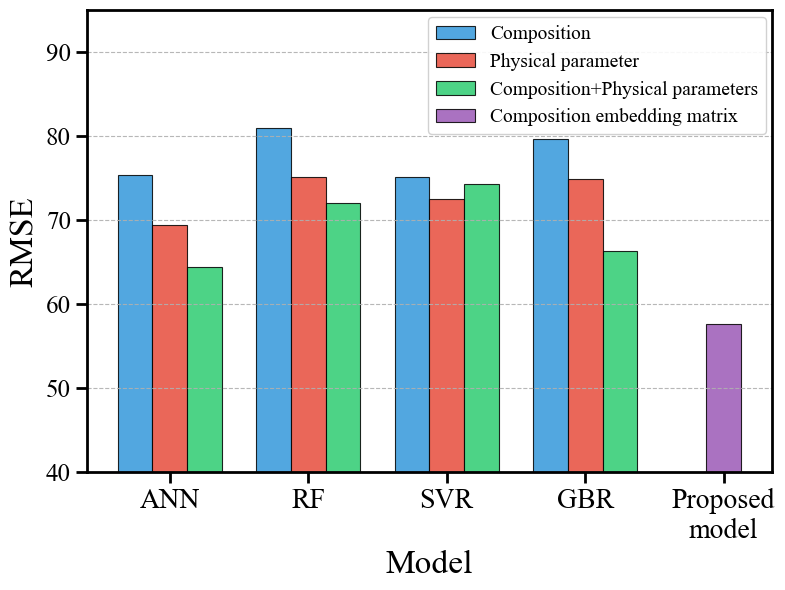

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# ============================================================================
# 读取CSV数据
# ============================================================================

# 如果有实际CSV文件，取消下面注释
df = pd.read_csv("model_comparison_results.csv")

# 筛选指定的模型
selected_models = ['ANN', 'RF', 'SVR', 'GBR']
df_filtered = df[df['Model'].isin(selected_models)]

# 特征组合列表
feature_combinations = ['Composition Only', 'Physical Only', 'Composition+Physical']

# ============================================================================
# 构建结果字典
# ============================================================================

results = {}
for model in selected_models:
    results[model] = {}
    for feature in feature_combinations:
        row = df_filtered[(df_filtered['Model'] == model) & 
                          (df_filtered['Feature Combination'] == feature)]
        if not row.empty:
            results[model][feature] = {
                'mean_RMSE': float(row['Mean RMSE'].values[0]),
                'std_RMSE': float(row['RMSE Std'].values[0])
            }

# ============================================================================
# 添加 my_model 结果
# ============================================================================

my_model_rmse_values = [
    52.945285977991084, 39.539798845833644, 44.94547082739405, 
    84.15736630635082, 56.726995125870886, 38.89198201801295, 
    72.31179877198552, 87.02737742075261, 46.032211542704424, 
    53.4713816399265
]

my_model_mean_rmse = np.mean(my_model_rmse_values)
my_model_std_rmse = np.std(my_model_rmse_values)

print(f"the proposed model - Mean RMSE: {my_model_mean_rmse:.4f}, Std RMSE: {my_model_std_rmse:.4f}")

# ============================================================================
# 绘制RMSE柱状图
# ============================================================================


plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'  # 数学字体也使用类似Times的样式



# 模型名称列表（前4个有3个柱，the proposed model只有1个柱）
model_names_main = ['ANN', 'RF', 'SVR', 'GBR']
model_keys_main = ['ANN', 'RF', 'SVR', 'GBR']

fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.25
x_pos_main = np.arange(len(model_names_main))

colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']  # 添加第4种颜色给the proposed model
feature_labels = ['Composition', 'Physical parameter', 'Composition+Physical parameters']

# 绘制前4个模型的3组柱状图
for i, feature_name in enumerate(feature_combinations):
    rmse_values = []
    rmse_stds = []
    
    for model_key in model_keys_main:
        if feature_name in results.get(model_key, {}):
            rmse_values.append(results[model_key][feature_name]['mean_RMSE'])
            rmse_stds.append(results[model_key][feature_name]['std_RMSE'])
        else:
            rmse_values.append(np.nan)
            rmse_stds.append(0)
    
    ax.bar(x_pos_main + i*bar_width, rmse_values, bar_width, 
        #    yerr=rmse_stds,
           capsize=4, label=feature_labels[i], 
           color=colors[i], alpha=0.85, edgecolor='black', linewidth=0.8)

# 绘制 the proposed model 单独的柱（居中）
my_model_x = len(model_names_main)  # the proposed model的x位置
ax.bar(my_model_x + bar_width, my_model_mean_rmse, bar_width, 
    #    yerr=my_model_std_rmse,
       capsize=4, label='Composition embedding matrix', 
       color=colors[3], alpha=0.85, edgecolor='black', linewidth=0.8)

# 设置x轴刻度位置和标签
all_model_names = model_names_main + ['Proposed\nmodel']
# 前4个模型的刻度在3个柱的中间，the proposed model的刻度在单个柱的中间
x_ticks = list(x_pos_main + bar_width) + [my_model_x + bar_width]

ax.set_xticks(x_ticks)
ax.set_xticklabels(all_model_names, fontsize=20) #, fontweight='bold')

# 设置坐标轴标签
ax.set_xlabel('Model', fontsize=24) #, fontweight='bold')
ax.set_ylabel('RMSE', fontsize=24) #, fontweight='bold')

# 设置y轴刻度字体大小
ax.tick_params(axis='y', labelsize=18, width=2, length=8)
ax.tick_params(axis='x', width=2, length=8)

# 设置图例
ax.legend(loc='upper right', bbox_to_anchor=(1.005, 1.005), fontsize=14, framealpha=0.9)

# 设置网格
ax.grid(True, alpha=0.9, axis='y', linestyle='--')

# 设置y轴范围
# ax.set_ylim(0, ax.get_ylim()[1] * 1.1)
ax.set_ylim(40, 95)

# 加粗坐标轴边框
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.tight_layout()
plt.savefig('rmse_model_comparison.png', dpi = 1200, bbox_inches='tight')
print("\n图表已保存至 'rmse_model_comparison.png'")

# ============================================================================
# 打印数据摘要
# ============================================================================

print("\n" + "="*70)
print("RMSE Results Summary")
print("="*70)

print(f"\n{'Model':<20}{'Feature Combination':<30}{'Mean RMSE':<15}{'Std RMSE':<15}")
print("-"*80)

for model_key, model_name in zip(model_keys_main, model_names_main):
    for feature in feature_combinations:
        if feature in results.get(model_key, {}):
            mean_rmse = results[model_key][feature]['mean_RMSE']
            std_rmse = results[model_key][feature]['std_RMSE']
            print(f"{model_name:<20}{feature:<30}{mean_rmse:<15.4f}{std_rmse:<15.4f}")

print(f"{'the proposed model':<20}{'Composition embedding matrix':<30}{my_model_mean_rmse:<15.4f}{my_model_std_rmse:<15.4f}")